<a href="https://colab.research.google.com/github/nkhar21/ML_4/blob/main/FER_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
replace example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import pandas as pd

example_submission_df = pd.read_csv('example_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
import numpy as np

# Convert pixel strings to numpy arrays
def process_pixels(pixels_str):
    return np.array(pixels_str.split(), dtype='float32')

# For training
train_df['pixels'] = train_df['pixels'].apply(process_pixels)
x_train = np.stack(train_df['pixels'].values)
y_train = train_df['emotion'].values

# For testing
test_df['pixels'] = test_df['pixels'].apply(process_pixels)
x_test = np.stack(test_df['pixels'].values)

# Normalize and reshape
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)

x_test.shape, x_train.shape, y_train.shape

((7178, 48, 48, 1), (28709, 48, 48, 1), (28709,))

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets (e.g. 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

x_train.shape, x_test.shape, y_train.shape, x_val.shape, y_val.shape

((22967, 48, 48, 1), (7178, 48, 48, 1), (22967,), (5742, 48, 48, 1), (5742,))

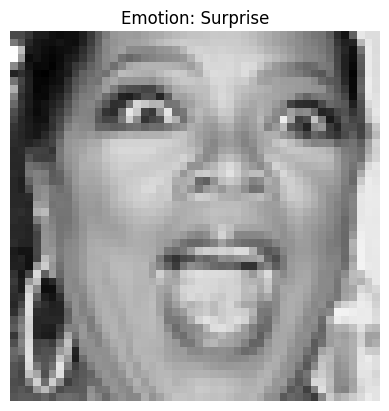

In [ ]:
import matplotlib.pyplot as plt
idx = 4


emotion_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

plt.imshow(x_train[idx].squeeze(), cmap='gray')
plt.title(f'Emotion: {emotion_dict[y_train[idx]]}')
plt.axis('off')
plt.show()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# f8a227b42dc881e037b25911fa86b8a491fc0581
!pip install wandb
import wandb
wandb.login()

True

In [ ]:
# === 0. YOUR HELPER EVALUATE FUNCTION ===
def evaluate_model(
    x_data, y_data, model, loss_fn, device,
    train_mode=False, optimizer=None, batch_size=64
):
    # 1. Convert x_data → FloatTensor on CPU, then permute to (N,1,48,48)
    if isinstance(x_data, torch.Tensor):
        x_tensor = x_data.float()
    else:
        x_tensor = torch.tensor(x_data, dtype=torch.float32)
    x_tensor = x_tensor.permute(0, 3, 1, 2)  # (N,1,48,48)

    # ────────── NEW: normalize exactly like train_transforms ──────────
    # train_transforms did: ToTensor() then Normalize(mean=0.5,std=0.5).
    # Since x_tensor is now in [0,1], do (x–0.5)/0.5 to match.
    x_tensor = (x_tensor - 0.5) / 0.5

    # 2. Convert y_data → LongTensor of shape (N,)
    if isinstance(y_data, torch.Tensor):
        y_tensor = y_data.long()
    else:
        y_tensor = torch.tensor(y_data, dtype=torch.long)

    # 3. Build DataLoader
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train_mode)

    # 4. Set model mode
    model.to(device)
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    # 5. Loop over batches
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)   # shape: (B,1,48,48)
        y_batch = y_batch.to(device)

        if train_mode:
            optimizer.zero_grad()

        outputs = model(x_batch)       # (B,7)
        loss = loss_fn(outputs, y_batch)
        total_loss += loss.item() * x_batch.size(0)

        if train_mode:
            loss.backward()
            optimizer.step()

        preds = outputs.argmax(dim=1)  # (B,)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Training 1 - Data aug 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# === 1. MODEL DEFINITION ===
class FERCNN_With_BatchNorm(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(FERCNN_With_BatchNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# === 1. CUSTOM DATASET WITH AUGMENTATION ===
class FER2013Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: NumPy array of shape (N, 48, 48, 1)
        labels: NumPy array of shape (N,)
        transform: torchvision.transforms to apply to each PIL image.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]                     # shape (48, 48, 1)
        img = img.squeeze(-1)                      # shape (48, 48)
        img = Image.fromarray(img.astype(np.uint8), mode="L")
        if self.transform:
            img = self.transform(img)              # now a tensor (1, 48, 48)
        label = int(self.labels[idx])
        return img, label

In [ ]:
# === 2. DEFINE AUGMENTATION TRANSFORMS ===
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),                # ±10°
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ToTensor(),                        # → [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5])   # → roughly [-1,1]
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# === 3. TRAINING FUNCTION (uses evaluate_model for validation) ===
def train_model_with_batchnorm_aug(
    x_train, y_train, x_val, y_val,
    epochs=20,
    lr=0.001,
    dropout_rate=0.3,
    weight_decay=1e-5,
    patience=5,
    batch_size=64
):
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"Augmented_1_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}",
        config={
            "dropout_rate": dropout_rate,
            "pool_kernel": (2, 2),
            "epochs": epochs,
            "batch_size": batch_size,
            "lr": lr,
            "weight_decay": weight_decay,
            "early_stopping_patience": patience,
            "augmentation": True
        }
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 4a. Build train/val datasets & loaders
    train_dataset = FER2013Dataset(x_train, y_train, transform=train_transforms)
    val_dataset = FER2013Dataset(x_val, y_val, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    # For validation, we'll NOT use evaluate_model's DataLoader but pass raw x_val/y_val into evaluate_model

    # 4b. Build model, optimizer, loss, scheduler
    model = FERCNN_With_BatchNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)
    wandb.watch(model)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        # ---- TRAIN LOOP ----
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, labels in train_loader:
            imgs = imgs.to(device)            # (B, 1, 48, 48)
            labels = labels.to(device)         # (B,)

            optimizer.zero_grad()
            outputs = model(imgs)              # (B, 7)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_train_loss / total_train
        train_acc = correct_train / total_train

        # ---- VALIDATION LOOP via evaluate_model ----
        val_loss, val_acc = evaluate_model(
            x_val, y_val,
            model, loss_fn, device,
            train_mode=False,
            optimizer=None,
            batch_size=batch_size
        )

        # ---- SCHEDULER & EARLY STOPPING ----
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"  ⛔ Early stopping at epoch {epoch+1}")
                break

        # ---- OVERFITTING METRICS & LOGGING ----
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
            "lr": optimizer.param_groups[0]["lr"]
        })

    run.finish()

In [ ]:
train_model_with_batchnorm_aug(
    x_train, y_train, x_val, y_val,
    epochs=30,
    lr=0.0015,
    dropout_rate=0.3,
    weight_decay=1e-5,
    patience=8,
    batch_size=128
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30
  Train Loss: 1.8361 | Train Acc: 0.2418
  Val   Loss: 1.8176 | Val   Acc: 0.2513
  Loss Gap:   0.0186 | Acc  Gap:  -0.0095
  Loss Ratio: 1.0102 | Acc Ratio: 0.9623
Epoch 2/30
  Train Loss: 1.8190 | Train Acc: 0.2508
  Val   Loss: 1.8257 | Val   Acc: 0.2513
  Loss Gap:   -0.0067 | Acc  Gap:  -0.0005
  Loss Ratio: 0.9964 | Acc Ratio: 0.9981
Epoch 3/30
  Train Loss: 1.8165 | Train Acc: 0.2513
  Val   Loss: 1.8214 | Val   Acc: 0.2513
  Loss Gap:   -0.0049 | Acc  Gap:  -0.0000
  Loss Ratio: 0.9973 | Acc Ratio: 0.9999
Epoch 4/30
  Train Loss: 1.8151 | Train Acc: 0.2513
  Val   Loss: 1.8133 | Val   Acc: 0.2513
  Loss Gap:   0.0018 | Acc  Gap:  0.0000
  Loss Ratio: 1.0010 | Acc Ratio: 1.0000
Epoch 5/30
  Train Loss: 1.8138 | Train Acc: 0.2513
  Val   Loss: 2.0380 | Val   Acc: 0.2513
  Loss Gap:   -0.2242 | Acc  Gap:  0.0000
  Loss Ratio: 0.8900 | Acc Ratio: 1.0000
Epoch 6/30
  Train Loss: 1.8129 | Train Acc: 0.2513
  Val   Loss: 5.2344 | Val   Acc: 0.2513
  Loss Gap:   -3.4216 | Ac

acc_gap,▁▁▁▁▁▁█▆▇▇█
acc_ratio,▁▁▁▁▁▁█▅▆▆▇
epoch,▁▂▂▃▄▅▅▆▇▇█
loss_gap,█████▇▁▆▆▇▇
loss_ratio,████▇▃▁▂▂▂▃
lr,▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁██████████
train_loss,█▃▃▂▂▂▁▁▁▁▁
val_accuracy,██████▁▃▂▂▂
val_loss,▁▁▁▁▁▂█▃▃▂▂
acc_gap,0.13063


In [ ]:
train_model_with_batchnorm_aug(
    x_train, y_train, x_val, y_val,
    epochs=30,
    lr=0.0015,
    dropout_rate=0.3,
    weight_decay=1e-5,
    patience=8,
    batch_size=128
)


acc_gap,▁████████
acc_ratio,▁████████
epoch,▁▂▃▄▅▅▆▇█
loss_gap,█▁▂▆█████
loss_ratio,█▁▂▆█████
lr,▁▁▁▁▁▁▁▁▁
train_accuracy,▁████████
train_loss,█▃▃▂▂▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▃▂▁▁▁▁
acc_gap,1e-05


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30
  Train Loss: 1.8341 | Train Acc: 0.2370
  Val   Loss: 1.8291 | Val   Acc: 0.2513
  Loss Gap:   0.0050 | Acc  Gap:  -0.0143
  Loss Ratio: 1.0027 | Acc Ratio: 0.9432
Epoch 2/30
  Train Loss: 1.8192 | Train Acc: 0.2511
  Val   Loss: 1.8304 | Val   Acc: 0.2513
  Loss Gap:   -0.0112 | Acc  Gap:  -0.0002
  Loss Ratio: 0.9939 | Acc Ratio: 0.9994
Epoch 3/30
  Train Loss: 1.8164 | Train Acc: 0.2511
  Val   Loss: 1.8255 | Val   Acc: 0.2513
  Loss Gap:   -0.0091 | Acc  Gap:  -0.0003
  Loss Ratio: 0.9950 | Acc Ratio: 0.9990
Epoch 4/30
  Train Loss: 1.8150 | Train Acc: 0.2513
  Val   Loss: 1.8147 | Val   Acc: 0.2513
  Loss Gap:   0.0003 | Acc  Gap:  -0.0000
  Loss Ratio: 1.0002 | Acc Ratio: 0.9999
Epoch 5/30
  Train Loss: 1.8137 | Train Acc: 0.2513
  Val   Loss: 1.8103 | Val   Acc: 0.2513
  Loss Gap:   0.0035 | Acc  Gap:  0.0000
  Loss Ratio: 1.0019 | Acc Ratio: 1.0000
Epoch 6/30
  Train Loss: 1.8111 | Train Acc: 0.2513
  Val   Loss: 1.8092 | Val   Acc: 0.2513
  Loss Gap:   0.0019 | Acc

KeyboardInterrupt: 

# Training 2 - fix aug

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import wandb

class FERDataset(torch.utils.data.Dataset):
    """Custom dataset that applies transforms to FER2013 data"""
    def __init__(self, x_data, y_data, transform=None):
        # Convert to tensors if numpy arrays
        if isinstance(x_data, np.ndarray):
            # x_data shape: (N, 48, 48, 1) -> (N, 48, 48)
            self.x_data = torch.tensor(x_data.squeeze(-1), dtype=torch.float32)
        else:
            self.x_data = x_data.squeeze(-1).float()

        if isinstance(y_data, np.ndarray):
            self.y_data = torch.tensor(y_data, dtype=torch.long)
        else:
            self.y_data = y_data.long()

        self.transform = transform

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        image = self.x_data[idx]  # Shape: (48, 48)
        label = self.y_data[idx]

        if self.transform:
            # Add channel dimension for transforms: (48, 48) -> (1, 48, 48)
            image = image.unsqueeze(0)
            image = self.transform(image)
        else:
            # Just add channel dimension
            image = image.unsqueeze(0)

        return image, label

In [ ]:
# Define augmentation transforms
def get_train_transforms():
    return transforms.Compose([
        # Random horizontal flip (emotions can be mirrored)
        transforms.RandomHorizontalFlip(p=0.5),

        # Random rotation (small angles to avoid distorting face too much)
        transforms.RandomRotation(degrees=10),

        # Random affine transformations (slight shifts and scaling)
        transforms.RandomAffine(
            degrees=0,  # No additional rotation beyond RandomRotation
            translate=(0.1, 0.1),  # 10% translation in each direction
            scale=(0.9, 1.1),  # Scale between 90% and 110%
            shear=5  # Small shear transformation
        ),

        # Random erasing (randomly erase rectangular regions)
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),

        # Add some noise by slightly adjusting brightness and contrast
        transforms.ColorJitter(brightness=0.2, contrast=0.2),

        # Normalize to ensure values stay in reasonable range
        transforms.Normalize(mean=[0.5], std=[0.5])  # Maps [0,1] to [-1,1]
    ])

def get_val_transforms():
    return transforms.Compose([
        # Only normalization for validation (no augmentation)
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [ ]:
class FERCNN_With_BatchNorm(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(FERCNN_With_BatchNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [ ]:
def evaluate_model_with_augmentation(
    dataset,
    model,
    loss_fn,
    device,
    train_mode=False,
    optimizer=None,
    batch_size=64
):
    """
    Evaluate model using custom dataset with augmentation support
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train_mode)

    model.to(device)
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        if train_mode:
            optimizer.zero_grad()

        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        total_loss += loss.item() * x_batch.size(0)

        if train_mode:
            loss.backward()
            optimizer.step()

        preds = outputs.argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
def train_model_with_augmentation(epochs=20, lr=0.001, dropout_rate=0.3):
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"FER_Augmented_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}",
        config={
            "dropout_rate": dropout_rate,
            "pool_kernel": (2, 2),
            "epochs": epochs,
            "batch_size": 64,
            "lr": lr,
            "augmentation": True
        }
    )

    batch_size = 64
    model = FERCNN_With_BatchNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    wandb.watch(model)

    # Create datasets with transforms
    train_dataset = FERDataset(x_train, y_train, transform=get_train_transforms())
    val_dataset = FERDataset(x_val, y_val, transform=get_val_transforms())

    for epoch in range(epochs):
        train_loss, train_acc = evaluate_model_with_augmentation(
            train_dataset, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_model_with_augmentation(
            val_dataset, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=batch_size
        )

        # Overfitting metrics
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
        })

    run.finish()
    return model

In [ ]:
# Additional improvements you can try:
def train_model_with_advanced_techniques(epochs=30, lr=0.001, dropout_rate=0.5):
    """
    Training with additional techniques for better performance
    """
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"FER_Advanced_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}",
        config={
            "dropout_rate": dropout_rate,
            "epochs": epochs,
            "batch_size": 64,
            "lr": lr,
            "scheduler": "StepLR",
            "augmentation": True,
            "label_smoothing": 0.1
        }
    )

    batch_size = 64
    model = FERCNN_With_BatchNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Add weight decay

    # Label smoothing for better generalization
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    wandb.watch(model)

    # Create datasets with transforms
    train_dataset = FERDataset(x_train, y_train, transform=get_train_transforms())
    val_dataset = FERDataset(x_val, y_val, transform=get_val_transforms())

    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = evaluate_model_with_augmentation(
            train_dataset, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_model_with_augmentation(
            val_dataset, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=batch_size
        )

        # Step the scheduler
        scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_fer_model.pth')

        # Overfitting metrics
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{epochs} (LR: {current_lr:.6f})")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Best Val Acc: {best_val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "best_val_accuracy": best_val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "learning_rate": current_lr,
        })

    run.finish()
    return model

In [ ]:
model = train_model_with_augmentation(epochs=25, lr=0.0015, dropout_rate=0.4)

Epoch 1/25
  Train Loss: 1.8352 | Train Acc: 0.2382
  Val   Loss: 1.8085 | Val   Acc: 0.2576
  Loss Gap:   0.0268 | Acc  Gap:  -0.0194
  Loss Ratio: 1.0148 | Acc Ratio: 0.9247
Epoch 2/25
  Train Loss: 1.8053 | Train Acc: 0.2512
  Val   Loss: 1.7880 | Val   Acc: 0.2513
  Loss Gap:   0.0173 | Acc  Gap:  -0.0001
  Loss Ratio: 1.0097 | Acc Ratio: 0.9997
Epoch 3/25
  Train Loss: 1.7600 | Train Acc: 0.2777
  Val   Loss: 1.6334 | Val   Acc: 0.3293
  Loss Gap:   0.1266 | Acc  Gap:  -0.0516
  Loss Ratio: 1.0775 | Acc Ratio: 0.8432
Epoch 4/25
  Train Loss: 1.6805 | Train Acc: 0.3149
  Val   Loss: 1.5518 | Val   Acc: 0.3650
  Loss Gap:   0.1287 | Acc  Gap:  -0.0501
  Loss Ratio: 1.0829 | Acc Ratio: 0.8628
Epoch 5/25
  Train Loss: 1.6071 | Train Acc: 0.3506
  Val   Loss: 1.4742 | Val   Acc: 0.4241
  Loss Gap:   0.1329 | Acc  Gap:  -0.0735
  Loss Ratio: 1.0902 | Acc Ratio: 0.8267
Epoch 6/25
  Train Loss: 1.5559 | Train Acc: 0.3779
  Val   Loss: 1.4148 | Val   Acc: 0.4432
  Loss Gap:   0.1411 | Acc 

acc_gap,▆█▃▃▁▂▂▃▃▂▄▃▃▂▄▄▃▂▂▂▁▂▃▃▂
acc_ratio,▅█▂▂▁▂▂▄▄▃▄▄▄▃▅▄▄▃▃▄▃▄▄▄▄
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss_gap,▁▁▇▇▇▇▇▇▇▇▆▅▇▇▇▆▆▇▇█▇████
loss_ratio,▁▁▅▅▅▆▆▆▇▆▆▅▆▇▆▆▆▇▇█▇▇███
train_accuracy,▁▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇██████
train_loss,██▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▁▃▃▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,██▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
acc_gap,-0.06154
acc_ratio,0.89423


In [ ]:
model = train_model_with_augmentation(epochs=30, lr=0.001, dropout_rate=0.3)

Epoch 1/30
  Train Loss: 1.8166 | Train Acc: 0.2429
  Val   Loss: 1.7305 | Val   Acc: 0.2851
  Loss Gap:   0.0860 | Acc  Gap:  -0.0422
  Loss Ratio: 1.0497 | Acc Ratio: 0.8519
Epoch 2/30
  Train Loss: 1.6894 | Train Acc: 0.3109
  Val   Loss: 1.5092 | Val   Acc: 0.4051
  Loss Gap:   0.1802 | Acc  Gap:  -0.0942
  Loss Ratio: 1.1194 | Acc Ratio: 0.7676
Epoch 3/30
  Train Loss: 1.5836 | Train Acc: 0.3701
  Val   Loss: 1.4601 | Val   Acc: 0.4324
  Loss Gap:   0.1234 | Acc  Gap:  -0.0624
  Loss Ratio: 1.0845 | Acc Ratio: 0.8558
Epoch 4/30
  Train Loss: 1.5218 | Train Acc: 0.3994
  Val   Loss: 1.3596 | Val   Acc: 0.4690
  Loss Gap:   0.1622 | Acc  Gap:  -0.0696
  Loss Ratio: 1.1193 | Acc Ratio: 0.8516
Epoch 5/30
  Train Loss: 1.4781 | Train Acc: 0.4211
  Val   Loss: 1.3502 | Val   Acc: 0.4706
  Loss Gap:   0.1279 | Acc  Gap:  -0.0494
  Loss Ratio: 1.0947 | Acc Ratio: 0.8949
Epoch 6/30
  Train Loss: 1.4393 | Train Acc: 0.4387
  Val   Loss: 1.3115 | Val   Acc: 0.4894
  Loss Gap:   0.1278 | Acc 

acc_gap,▇▁▅▄▆▆▅▇█▅▅▆▅▅▇▆▅█▅▆▅▅▅▆▇▇▆▆▅▆
acc_ratio,▄▁▅▄▆▆▆▇█▆▆▆▆▆▇▆▆█▆▇▆▆▆▇▇▇▇▇▇▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss_gap,▂█▄▇▅▅▆▂▂▄▅▄▅▄▄▅▄▁▅▄▆▅▅▄▃▄▅▄▅▅
loss_ratio,▁▇▄▇▅▅▆▃▃▄▆▆▆▅▆▇▅▂▆▆██▇▆▄▅▇▅▇█
train_accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▇▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇█████
val_loss,█▆▅▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
acc_gap,-0.05257
acc_ratio,0.91271


In [ ]:
model = train_model_with_augmentation(epochs=50, lr=0.0016, dropout_rate=0.25)

Epoch 1/50
  Train Loss: 1.8279 | Train Acc: 0.2440
  Val   Loss: 1.7730 | Val   Acc: 0.2520
  Loss Gap:   0.0550 | Acc  Gap:  -0.0080
  Loss Ratio: 1.0310 | Acc Ratio: 0.9683
Epoch 2/50
  Train Loss: 1.7579 | Train Acc: 0.2776
  Val   Loss: 1.6247 | Val   Acc: 0.3427
  Loss Gap:   0.1332 | Acc  Gap:  -0.0652
  Loss Ratio: 1.0820 | Acc Ratio: 0.8099
Epoch 3/50
  Train Loss: 1.6311 | Train Acc: 0.3479
  Val   Loss: 1.4836 | Val   Acc: 0.4310
  Loss Gap:   0.1475 | Acc  Gap:  -0.0831
  Loss Ratio: 1.0994 | Acc Ratio: 0.8071
Epoch 4/50
  Train Loss: 1.5513 | Train Acc: 0.3882
  Val   Loss: 1.3875 | Val   Acc: 0.4730
  Loss Gap:   0.1639 | Acc  Gap:  -0.0848
  Loss Ratio: 1.1181 | Acc Ratio: 0.8206
Epoch 5/50
  Train Loss: 1.4912 | Train Acc: 0.4182
  Val   Loss: 1.3426 | Val   Acc: 0.4822
  Loss Gap:   0.1486 | Acc  Gap:  -0.0641
  Loss Ratio: 1.1106 | Acc Ratio: 0.8671
Epoch 6/50
  Train Loss: 1.4506 | Train Acc: 0.4333
  Val   Loss: 1.3211 | Val   Acc: 0.4901
  Loss Gap:   0.1295 | Acc 

acc_gap,█▃▁▁▃▅▄▄▄▄▄▄▅▅▄▄▄▄▄▄▅▄▅▄▅▅▅▅▆▄▆▅▆▇▅▅▆▆▇▆
acc_ratio,█▁▁▂▄▅▅▅▅▅▅▆▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▇█▇█▇▇█▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss_gap,▁▆█▇▆▇▆▆▆▇▇▆▅▆▇▄▆▅▅▅▅▅▄▅▃▄▄▅▅▃▅▃▂▃▃▃▄▃▃▃
loss_ratio,▁▅▆▇▆▆▇▆▇▇██▆▆▇▆▅▇▇▆▆▆▆▇▆▅▆▇▇▄▆▅▃▅▄▅▅▄▄▅
train_accuracy,▁▂▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
val_loss,█▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_gap,-0.02906
acc_ratio,0.9526


In [ ]:
model = train_model_with_advanced_techniques(epochs=60, lr=0.0015, dropout_rate=0.5)

Epoch 1/60 (LR: 0.001500)
  Train Loss: 1.8689 | Train Acc: 0.2363
  Val   Loss: 1.8400 | Val   Acc: 0.2513
  Best Val Acc: 0.2513
  Loss Gap:   0.0289 | Acc  Gap:  -0.0151
Epoch 2/60 (LR: 0.001500)
  Train Loss: 1.8255 | Train Acc: 0.2621
  Val   Loss: 1.8169 | Val   Acc: 0.2717
  Best Val Acc: 0.2717
  Loss Gap:   0.0087 | Acc  Gap:  -0.0096
Epoch 3/60 (LR: 0.001500)
  Train Loss: 1.8016 | Train Acc: 0.2843
  Val   Loss: 1.7478 | Val   Acc: 0.3224
  Best Val Acc: 0.3224
  Loss Gap:   0.0538 | Acc  Gap:  -0.0381
Epoch 4/60 (LR: 0.001500)
  Train Loss: 1.7864 | Train Acc: 0.2931
  Val   Loss: 1.7367 | Val   Acc: 0.3213
  Best Val Acc: 0.3224
  Loss Gap:   0.0498 | Acc  Gap:  -0.0282
Epoch 5/60 (LR: 0.001500)
  Train Loss: 1.7751 | Train Acc: 0.2993
  Val   Loss: 1.7184 | Val   Acc: 0.3319
  Best Val Acc: 0.3319
  Loss Gap:   0.0567 | Acc  Gap:  -0.0326
Epoch 6/60 (LR: 0.001500)
  Train Loss: 1.7439 | Train Acc: 0.3115
  Val   Loss: 1.6230 | Val   Acc: 0.3727
  Best Val Acc: 0.3727
  Lo

In [ ]:
model_advanced_1 = train_model_with_advanced_techniques(epochs=60, lr=0.0015, dropout_rate=0.5)

Epoch 1/60 (LR: 0.001500)
  Train Loss: 1.8653 | Train Acc: 0.2352
  Val   Loss: 1.8333 | Val   Acc: 0.2513
  Best Val Acc: 0.2513
  Loss Gap:   0.0320 | Acc  Gap:  -0.0161
Epoch 2/60 (LR: 0.001500)
  Train Loss: 1.8396 | Train Acc: 0.2500
  Val   Loss: 1.8231 | Val   Acc: 0.2515
  Best Val Acc: 0.2515
  Loss Gap:   0.0165 | Acc  Gap:  -0.0015
Epoch 3/60 (LR: 0.001500)
  Train Loss: 1.8317 | Train Acc: 0.2565
  Val   Loss: 1.8071 | Val   Acc: 0.2530
  Best Val Acc: 0.2530
  Loss Gap:   0.0246 | Acc  Gap:  0.0035
Epoch 4/60 (LR: 0.001500)
  Train Loss: 1.8109 | Train Acc: 0.2676
  Val   Loss: 1.7393 | Val   Acc: 0.3015
  Best Val Acc: 0.3015
  Loss Gap:   0.0717 | Acc  Gap:  -0.0339
Epoch 5/60 (LR: 0.001500)
  Train Loss: 1.7642 | Train Acc: 0.2907
  Val   Loss: 1.6626 | Val   Acc: 0.3814
  Best Val Acc: 0.3814
  Loss Gap:   0.1016 | Acc  Gap:  -0.0907
Epoch 6/60 (LR: 0.001500)
  Train Loss: 1.7221 | Train Acc: 0.3224
  Val   Loss: 1.6159 | Val   Acc: 0.3962
  Best Val Acc: 0.3962
  Los

acc_gap,▇█▅▁▂▃▅▄▄▃▃▃▄▃▄▃▄▃▄▄▅▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅
best_val_accuracy,▁▁▂▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████████
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
learning_rate,██████▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gap,▁▂▅██▆▇▇▆▆▇▇█▇▇▇█▇▇▇▆▇▆▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆▅
train_accuracy,▁▁▂▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,███▇▇▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████
val_loss,██▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc_gap,-0.02862
best_val_accuracy,0.63218


# Save best model

In [ ]:
import wandb

# Start a run just for uploading the model (can be short)
run = wandb.init(project="ML_4", entity="nkhar21-student", name="upload_best_fer_model")

# Create an artifact
artifact = wandb.Artifact(name="best_fer_model", type="model")
artifact.add_file("best_fer_model.pth")

# Log the artifact
run.log_artifact(artifact)

run.finish()

# Trianing 3 - ResNet

In [ ]:
# 0 - Models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from PIL import Image
import random

# ResNet Building Blocks
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.dropout:
            out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.dropout:
            out = self.dropout(out)
        out = F.relu(self.bn2(self.conv2(out)))
        if self.dropout:
            out = self.dropout(out)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Model
class FERResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7, dropout_rate=0.5):
        super(FERResNet, self).__init__()
        self.in_planes = 64
        self.dropout_rate = dropout_rate

        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.dropout_rate * 0.3))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

# Factory functions for different ResNet variants
def FERResNet18(num_classes=7, dropout_rate=0.5):
    return FERResNet(BasicBlock, [2, 2, 2, 2], num_classes, dropout_rate)

def FERResNet34(num_classes=7, dropout_rate=0.5):
    return FERResNet(BasicBlock, [3, 4, 6, 3], num_classes, dropout_rate)

def FERResNet50(num_classes=7, dropout_rate=0.5):
    return FERResNet(Bottleneck, [3, 4, 6, 3], num_classes, dropout_rate)


In [ ]:
# 1 - Data Augementation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import random

class FERDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None, use_mixup=False, mixup_alpha=0.2):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.use_mixup = use_mixup
        self.mixup_alpha = mixup_alpha

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Handle different image shapes
        image = self.images[idx]

        # Handle different input formats
        if len(image.shape) == 1:
            # Flattened image (2304,) -> (48, 48)
            image = image.reshape(48, 48)
        elif len(image.shape) == 3:
            # Handle (48, 48, 1) or (1, 48, 48) formats
            if image.shape[-1] == 1:
                # (48, 48, 1) -> (48, 48)
                image = image.squeeze(-1)
            elif image.shape[0] == 1:
                # (1, 48, 48) -> (48, 48)
                image = image.squeeze(0)
            else:
                # If it's RGB or other format, take first channel
                image = image[:, :, 0] if image.shape[-1] > 1 else image[0, :, :]
        elif len(image.shape) == 2:
            # Already (48, 48), good to go
            pass
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")

        # Ensure we have the right data type and range
        if image.dtype != np.uint8:
            # If image is normalized (0-1), convert back to 0-255
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)

        # Convert to PIL Image
        image = Image.fromarray(image, mode='L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        if self.use_mixup and hasattr(self, 'training') and self.training:
            # Simple mixup implementation
            if random.random() < 0.5:
                mix_idx = random.randint(0, len(self.images) - 1)
                mix_image = self.images[mix_idx]

                # Handle different shapes for mix_image too
                if len(mix_image.shape) == 1:
                    mix_image = mix_image.reshape(48, 48)
                elif len(mix_image.shape) == 3:
                    if mix_image.shape[-1] == 1:
                        mix_image = mix_image.squeeze(-1)
                    elif mix_image.shape[0] == 1:
                        mix_image = mix_image.squeeze(0)
                    else:
                        mix_image = mix_image[:, :, 0] if mix_image.shape[-1] > 1 else mix_image[0, :, :]

                if mix_image.dtype != np.uint8:
                    if mix_image.max() <= 1.0:
                        mix_image = (mix_image * 255).astype(np.uint8)
                    else:
                        mix_image = mix_image.astype(np.uint8)

                mix_image = Image.fromarray(mix_image, mode='L')
                mix_label = self.labels[mix_idx]

                if self.transform:
                    mix_image = self.transform(mix_image)

                lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                image = lam * image + (1 - lam) * mix_image
                label = (label, mix_label, lam)

        return image, label

# Fixed Enhanced Data Augmentation
def get_train_transforms():
    return transforms.Compose([
        transforms.Resize((56, 56)),  # Slightly larger for random crop
        transforms.RandomCrop(48),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.3, contrast=0.3)
        ], p=0.3),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        ], p=0.2),
        transforms.ToTensor(),  # Convert to tensor first
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),  # Apply RandomErasing after ToTensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])

def get_val_transforms():
    return transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

# Alternative training transforms with more robust augmentation
def get_train_transforms_alternative():
    """Alternative transform pipeline that's more robust"""
    return transforms.Compose([
        transforms.Resize((52, 52)),  # Slightly larger for random crop
        transforms.RandomCrop(48, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.3),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.15, scale=(0.02, 0.12)),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [ ]:
# 2 - Evaluation
def evaluate_model_with_augmentation(model, test_loader, device, num_augmentations=5):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Test Time Augmentation (TTA)
            batch_predictions = []

            # Original image
            outputs = model(images)
            batch_predictions.append(F.softmax(outputs, dim=1))

            # Augmented versions
            for _ in range(num_augmentations - 1):
                # Random horizontal flip
                if random.random() > 0.5:
                    aug_images = torch.flip(images, dims=[3])
                else:
                    aug_images = images

                outputs = model(aug_images)
                batch_predictions.append(F.softmax(outputs, dim=1))

            # Average predictions
            avg_predictions = torch.mean(torch.stack(batch_predictions), dim=0)
            _, predicted = torch.max(avg_predictions, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, all_predictions, all_labels


In [ ]:
# 3 - Training
def train_model_with_advanced_techniques(model_type='resnet18', epochs=60, lr=0.0015,
                                       dropout_rate=0.5, batch_size=128,
                                       weight_decay=1e-4, save_path='fer_resnet_model.pth',
                                       x_train=None, y_train=None, x_val=None, y_val=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize model based on type - assuming these are imported from your models file
    if model_type == 'resnet18':
        model = FERResNet18(num_classes=7, dropout_rate=dropout_rate)
    elif model_type == 'resnet34':
        model = FERResNet34(num_classes=7, dropout_rate=dropout_rate)
    elif model_type == 'resnet50':
        model = FERResNet50(num_classes=7, dropout_rate=dropout_rate)
    else:
        raise ValueError("model_type must be 'resnet18', 'resnet34', or 'resnet50'")

    model = model.to(device)

    # Handle data - if not provided as parameters, try to use global variables
    if x_train is None:
        try:
            # Try to access global variables (modify variable names as needed)
            import sys
            frame = sys._getframe(1)
            x_train = frame.f_globals.get('x_train')
            y_train = frame.f_globals.get('y_train')
            x_val = frame.f_globals.get('x_val')
            y_val = frame.f_globals.get('y_val')

            if x_train is None:
                raise ValueError("Please provide training data as parameters or ensure x_train, y_train, x_val, y_val are available")
        except:
            raise ValueError("Please provide x_train, y_train, x_val, y_val as function parameters")

    print(f"Training data shape: {x_train.shape}, Validation data shape: {x_val.shape}")

    # Create datasets
    train_dataset = FERDataset(x_train, y_train, transform=get_train_transforms(), use_mixup=False)
    val_dataset = FERDataset(x_val, y_val, transform=get_val_transforms())

    # Create data loaders with num_workers=0 to avoid multiprocessing issues
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=0)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5,
                                verbose=True, min_lr=1e-6)

    # Training variables
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"Training {model_type.upper()} for {epochs} epochs...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Update learning rate
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'model_type': model_type,
                'dropout_rate': dropout_rate
            }, save_path)

        # Print progress
        print(f'Epoch {epoch+1}/{epochs} (LR: {current_lr:.6f})')
        print(f'  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'  Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}')
        print(f'  Best Val Acc: {best_val_acc:.4f}')
        print(f'  Loss Gap:   {avg_train_loss - avg_val_loss:.4f} | Acc  Gap:  {train_acc - val_acc:.4f}')
        print()

    print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
    print(f"Model saved as: {save_path}")

    # Load best model
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [ ]:
# 4 - Loading model
# Function to load saved model
def load_fer_resnet_model(model_path, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(model_path, map_location=device)
    model_type = checkpoint['model_type']
    dropout_rate = checkpoint['dropout_rate']

    if model_type == 'resnet18':
        model = FERResNet18(num_classes=7, dropout_rate=dropout_rate)
    elif model_type == 'resnet34':
        model = FERResNet34(num_classes=7, dropout_rate=dropout_rate)
    elif model_type == 'resnet50':
        model = FERResNet50(num_classes=7, dropout_rate=dropout_rate)

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    print(f"Loaded {model_type.upper()} model with validation accuracy: {checkpoint['best_val_acc']:.4f}")

    return model

In [ ]:
model_resnet18 = train_model_with_advanced_techniques(
    model_type='resnet18',
    epochs=60,
    lr=0.0015,
    dropout_rate=0.5,
    save_path='fer_resnet18_model.pth',
    x_train=x_train,  # your training data
    y_train=y_train,  # your training labels
    x_val=x_val,      # your validation data
    y_val=y_val       # your validation labels
)

Using device: cpu
Training data shape: (22967, 48, 48, 1), Validation data shape: (5742, 48, 48, 1)
Training RESNET18 for 60 epochs...
Model parameters: 11,173,831
Epoch 1/60 (LR: 0.001500)
  Train Loss: 1.8297 | Train Acc: 0.2611
  Val   Loss: 1.7137 | Val   Acc: 0.3457
  Best Val Acc: 0.3457
  Loss Gap:   0.1160 | Acc  Gap:  -0.0846

Epoch 2/60 (LR: 0.001500)
  Train Loss: 1.7165 | Train Acc: 0.3424
  Val   Loss: 1.7362 | Val   Acc: 0.3718
  Best Val Acc: 0.3718
  Loss Gap:   -0.0196 | Acc  Gap:  -0.0294

Epoch 3/60 (LR: 0.001500)
  Train Loss: 1.6585 | Train Acc: 0.3779
  Val   Loss: 1.5656 | Val   Acc: 0.4270
  Best Val Acc: 0.4270
  Loss Gap:   0.0929 | Acc  Gap:  -0.0491

Epoch 4/60 (LR: 0.001500)
  Train Loss: 1.6117 | Train Acc: 0.4101
  Val   Loss: 1.5088 | Val   Acc: 0.4592
  Best Val Acc: 0.4592
  Loss Gap:   0.1029 | Acc  Gap:  -0.0492

Epoch 5/60 (LR: 0.001500)
  Train Loss: 1.5669 | Train Acc: 0.4336
  Val   Loss: 1.5158 | Val   Acc: 0.4619
  Best Val Acc: 0.4619
  Loss G

KeyboardInterrupt: 

In [ ]:
# Train ResNet34 (deeper, might perform better)
# model_resnet34 = train_model_with_advanced_techniques(
#     model_type='resnet34',
#     epochs=60,
#     lr=0.001,  # Slightly lower LR for deeper model
#     dropout_rate=0.4,  # Less dropout for deeper model
#     save_path='fer_resnet34_model.pth'
# )

In [ ]:
# Train ResNet50 (deeper, might perform better)
# model_resnet50 = train_model_with_advanced_techniques(
#     model_type='resnet50',
#     epochs=60,
#     lr=0.0007,  # Slightly lower LR for deeper model
#     dropout_rate=0.25,  # Less dropout for deeper model
#     save_path='fer_resnet50_model.pth'
# )